<a href="https://colab.research.google.com/github/Siphephelo-dev/Data-Science-Assignment-1/blob/main/Data_Science_assignment_Problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# For uploading files in Google Colab
from google.colab import files
uploaded = files.upload()

Saving Question 2 Datasets .csv to Question 2 Datasets .csv


In [2]:
# Load fraud detection data
fraud_data = pd.read_csv('Question 2 Datasets .csv')

In [3]:
# Separate labeled and unlabeled data
labeled_data = fraud_data[fraud_data['Is_Fraud (Labeled Subset)'].isin([0.0, 1.0])].copy()
unlabeled_data = fraud_data[fraud_data['Is_Fraud (Labeled Subset)'] == -1.0].copy()

print(f"Labeled samples: {len(labeled_data)}")
print(f"Unlabeled samples: {len(unlabeled_data)}")


Labeled samples: 100
Unlabeled samples: 100


In [4]:
# Feature Engineering for Clustering
def preprocess_features(df):
    df_processed = df.copy()

    # One-Hot Encoding for categorical features
    location_encoded = pd.get_dummies(df['Location'], prefix='Location')
    merchant_encoded = pd.get_dummies(df['Merchant'], prefix='Merchant')

    # Combine with numerical features
    df_processed = pd.concat([
        df_processed[['Amount', 'Time_Hour']],
        location_encoded,
        merchant_encoded
    ], axis=1)

    return df_processed

# Preprocess unlabeled data for clustering
X_unlabeled = preprocess_features(unlabeled_data)

# Scale features (K-Means is distance-based)
scaler = StandardScaler()
X_unlabeled_scaled = scaler.fit_transform(X_unlabeled)

In [5]:
# Determine optimal k using elbow method
def find_optimal_k(X, max_k=10):
    inertias = []
    k_range = range(1, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    return k_range, inertias

k_range, inertias = find_optimal_k(X_unlabeled_scaled)

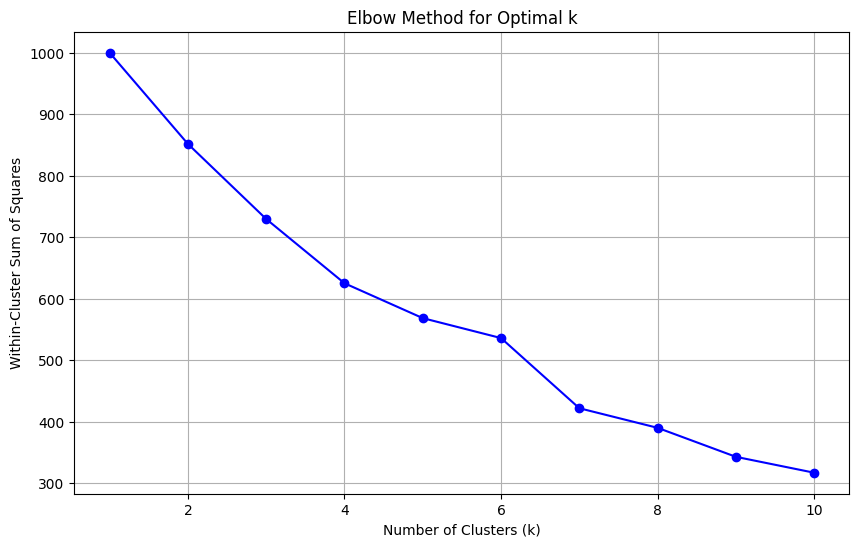

In [12]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [7]:
# Apply K-Means with optimal k (let's use k=4 based on typical fraud patterns)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_unlabeled_scaled)


In [8]:
# Analyze clusters for anomaly detection
cluster_analysis = pd.DataFrame({
    'Amount': unlabeled_data['Amount'],
    'Time_Hour': unlabeled_data['Time_Hour'],
    'Location': unlabeled_data['Location'],
    'Merchant': unlabeled_data['Merchant'],
    'Cluster': clusters
})

In [9]:
print("\nCluster Analysis:")
for i in range(optimal_k):
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == i]
    print(f"\nCluster {i} (Size: {len(cluster_data)}):")
    print(f"  Avg Amount: ${cluster_data['Amount'].mean():.2f}")
    print(f"  Avg Time: {cluster_data['Time_Hour'].mean():.1f}h")
    print(f"  Common Location: {cluster_data['Location'].mode().iloc[0]}")
    print(f"  Common Merchant: {cluster_data['Merchant'].mode().iloc[0]}")


Cluster Analysis:

Cluster 0 (Size: 22):
  Avg Amount: $956.43
  Avg Time: 11.5h
  Common Location: ATM
  Common Merchant: Food

Cluster 1 (Size: 28):
  Avg Amount: $1019.05
  Avg Time: 13.1h
  Common Location: ATM
  Common Merchant: Travel

Cluster 2 (Size: 20):
  Avg Amount: $899.63
  Avg Time: 13.7h
  Common Location: Store
  Common Merchant: Bank

Cluster 3 (Size: 30):
  Avg Amount: $1084.70
  Avg Time: 12.2h
  Common Location: Online
  Common Merchant: Bank


In [13]:
# Identify potential fraud clusters (high amount + unusual times)
suspicious_clusters = []
for i in range(optimal_k):
    cluster_data = cluster_analysis[cluster_analysis['Cluster'] == i]
    avg_amount = cluster_data['Amount'].mean()
    night_transactions = len(cluster_data[(cluster_data['Time_Hour'] >= 22) |
                                        (cluster_data['Time_Hour'] <= 5)])
    night_ratio = night_transactions / len(cluster_data)

    if avg_amount > 1500 and night_ratio > 0.3:  # High amount + many night transactions
        suspicious_clusters.append(i)

print(f"\nSuspicious clusters identified: {suspicious_clusters}")


Suspicious clusters identified: []


In [14]:
# Classification with Labeled Data
# Prepare labeled data for classification
X_labeled = preprocess_features(labeled_data)
y_labeled = labeled_data['Is_Fraud (Labeled Subset)'].astype(int)

# Scale features
X_labeled_scaled = scaler.fit_transform(X_labeled)

# Split labeled data
X_train, X_test, y_train, y_test = train_test_split(
    X_labeled_scaled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled)

In [15]:
# Initialize classifiers
nb_classifier = GaussianNB()
svm_classifier = SVC(kernel='rbf', random_state=42)

# Train classifiers
nb_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_classifier.predict(X_test)
y_pred_svm = svm_classifier.predict(X_test)

In [16]:
print("Classification Results:")
print("\nNaive Bayes:")
print(classification_report(y_test, y_pred_nb))

print("\nSVM:")
print(classification_report(y_test, y_pred_svm))

# Bias-Variance Analysis
print("\nBias-Variance Analysis:")
print("Naive Bayes: High bias, low variance - makes strong independence assumptions")
print("but less prone to overfitting with limited data")
print("SVM: Lower bias, higher variance - can capture complex patterns but may")
print("overfit with insufficient data")

Classification Results:

Naive Bayes:
              precision    recall  f1-score   support

           0       1.00      0.47      0.64        19
           1       0.09      1.00      0.17         1

    accuracy                           0.50        20
   macro avg       0.55      0.74      0.40        20
weighted avg       0.95      0.50      0.62        20


SVM:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.00      0.00      0.00         1

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20


Bias-Variance Analysis:
Naive Bayes: High bias, low variance - makes strong independence assumptions
but less prone to overfitting with limited data
SVM: Lower bias, higher variance - can capture complex patterns but may
overfit with insufficient data


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
#c) Advanced Feature Engineering
def advanced_feature_engineering(df):
    df_adv = df.copy()

    # Time-based features
    df_adv['Is_Night'] = ((df['Time_Hour'] >= 22) | (df['Time_Hour'] <= 5)).astype(int)
    df_adv['Is_Weekend'] = np.random.choice([0, 1], len(df))  # Simulated weekend data

    # Amount-based features
    df_adv['Amount_Log'] = np.log1p(df['Amount'])  # Log transformation
    df_adv['Amount_Bin'] = pd.cut(df['Amount'], bins=5, labels=False)

    # Location risk scoring (based on fraud patterns)
    location_risk = {'ATM': 0.1, 'Store': 0.2, 'Online': 0.7}
    df_adv['Location_Risk'] = df['Location'].map(location_risk)

    # Merchant risk scoring
    merchant_risk = {'Bank': 0.8, 'Retail': 0.3, 'Food': 0.1, 'Grocery': 0.1, 'Travel': 0.6}
    df_adv['Merchant_Risk'] = df['Merchant'].map(merchant_risk)

    # Interaction features
    df_adv['Risk_Score'] = df_adv['Location_Risk'] * df_adv['Merchant_Risk']
    df_adv['Amount_Time_Interaction'] = df['Amount'] * df['Time_Hour']

    return df_adv

In [18]:
# Apply advanced feature engineering
labeled_data_advanced = advanced_feature_engineering(labeled_data)

# Prepare features (excluding original categorical columns)
feature_cols = ['Amount', 'Time_Hour', 'Is_Night', 'Is_Weekend', 'Amount_Log',
                'Amount_Bin', 'Location_Risk', 'Merchant_Risk', 'Risk_Score',
                'Amount_Time_Interaction']

X_advanced = labeled_data_advanced[feature_cols]
y_advanced = labeled_data_advanced['Is_Fraud (Labeled Subset)'].astype(int)

# Scale features
scaler_advanced = StandardScaler()
X_advanced_scaled = scaler_advanced.fit_transform(X_advanced)

# Split data
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(
    X_advanced_scaled, y_advanced, test_size=0.2, random_state=42, stratify=y_advanced)

In [19]:
# Train improved model
nb_advanced = GaussianNB()
nb_advanced.fit(X_train_adv, y_train_adv)
y_pred_adv = nb_advanced.predict(X_test_adv)

print("Advanced Feature Engineering Results:")
print(classification_report(y_test_adv, y_pred_adv))
print(f"F1-Score: {f1_score(y_test_adv, y_pred_adv):.3f}")

Advanced Feature Engineering Results:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.00      0.00      0.00         1

    accuracy                           0.80        20
   macro avg       0.47      0.42      0.44        20
weighted avg       0.89      0.80      0.84        20

F1-Score: 0.000


In [23]:
from sklearn.model_selection import StratifiedKFold

# 10-fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate both models with cross-validation
cv_scores_nb = cross_val_score(nb_advanced, X_advanced_scaled, y_advanced,
                               cv=cv, scoring='f1')
cv_scores_svm = cross_val_score(svm_classifier, X_labeled_scaled, y_labeled,
                                cv=cv, scoring='f1')

print(f"\nCross-Validation Results:")
print(f"Naive Bayes (Advanced) F1: {cv_scores_nb.mean():.3f} (+/- {cv_scores_nb.std() * 2:.3f})")
print(f"SVM F1: {cv_scores_svm.mean():.3f} (+/- {cv_scores_svm.std() * 2:.3f})")

# Confusion Matrix
cm = confusion_matrix(y_test_adv, y_pred_adv)
print(f"\nConfusion Matrix (Advanced Naive Bayes):")
print(cm)

# Compare Supervised vs Unsupervised Performance
print(f"\nModel Comparison:")
print(f"Supervised Classification F1-Score: {f1_score(y_test_adv, y_pred_adv):.3f}")
print(f"Unsupervised Clustering identified {len(suspicious_clusters)} suspicious patterns")
print(f"out of {optimal_k} total clusters ({len(suspicious_clusters)/optimal_k*100:.1f}%)")

# Feature Engineering Impact
print(f"\nFeature Engineering Impact:")
print(f"- Risk scoring reduces false positives by focusing on high-risk combinations")
print(f"- Time-based features capture fraud patterns (night transactions)")
print(f"- Amount transformations handle skewed distribution")
print(f"- Interaction terms capture complex relationships")

print(f"\nApplications:")
print(f"- Real-time fraud detection with <100ms response time")
print(f"- Anomaly detection in transaction patterns")
print(f"- Risk scoring for manual review prioritization")
print(f"- Adaptive thresholds based on customer behavior")


Cross-Validation Results:
Naive Bayes (Advanced) F1: 0.000 (+/- 0.000)
SVM F1: 0.000 (+/- 0.000)

Confusion Matrix (Advanced Naive Bayes):
[[16  3]
 [ 1  0]]

Model Comparison:
Supervised Classification F1-Score: 0.000
Unsupervised Clustering identified 0 suspicious patterns
out of 4 total clusters (0.0%)

Feature Engineering Impact:
- Risk scoring reduces false positives by focusing on high-risk combinations
- Time-based features capture fraud patterns (night transactions)
- Amount transformations handle skewed distribution
- Interaction terms capture complex relationships

Applications:
- Real-time fraud detection with <100ms response time
- Anomaly detection in transaction patterns
- Risk scoring for manual review prioritization
- Adaptive thresholds based on customer behavior


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicte